In [7]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


### 1. Goal

Goal: Build a monthly forecast of wine volume using historical sales and a seasonal time-series mode

### 2. Load and review the data

What I’m doing: Import the dataset and confirm the structure, column names, and data types so calculations behave correctly.

In [5]:
df = pd.read_csv("Warehouse_and_Retail_Sales.csv")
df

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.00
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.00
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.00
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.00
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.00
...,...,...,...,...,...,...,...,...,...
307640,2020,9,DOPS INC,97896,ST PETERS ORGANIC ENG ALE NR 12/CS - 16.9OZ,BEER,0.00,0.0,1.00
307641,2020,9,ANHEUSER BUSCH INC,97918,STELLA ARTOIS 2/12 NR - 11.2OZ,BEER,372.45,315.0,3586.88
307642,2020,9,HEINEKEN USA,97942,TECATE 4/6 LNNR - 12OZ,BEER,7.79,0.0,4.00
307643,2020,9,RELIABLE CHURCHILL LLLP,97950,S SMITH WINTER WELCOME NR 12/CS - 18.7OZ,BEER,0.00,0.0,2.00


In [59]:
df.info
df.value_counts(df['SUPPLIER'])

SUPPLIER
REPUBLIC NATIONAL DISTRIBUTING CO       20767
LEGENDS LTD                             13598
SOUTHERN GLAZERS WINE AND SPIRITS       11649
E & J GALLO WINERY                      10816
THE COUNTRY VINTNER, LLC DBA WINEBOW    10656
                                        ...  
BARREL ONE INC                              1
TOBACCO BARN DISTILLERY                     1
BLACK ANKLE VINEYARDS LLC                   1
URUGUAY IMPORTS LTD                         1
G GAUTHIER CELLARS INC                      1
Name: count, Length: 388, dtype: int64

In [21]:
df.isna().sum()


YEAR                0
MONTH               0
SUPPLIER            0
ITEM CODE           0
ITEM DESCRIPTION    0
ITEM TYPE           0
RETAIL SALES        0
RETAIL TRANSFERS    0
WAREHOUSE SALES     0
TOTAL_VOLUME        0
MONTH_DATE          0
dtype: int64

### 3. Clean and standardize fields

What I’m doing: Convert numeric columns to numbers, handle any non-numeric values safely, and standardize text fields (like item type) to avoid mismatches.

In [41]:
# Here we separate sales
df.columns = df.columns.str.strip()

num_cols = ["RETAIL SALES", "RETAIL TRANSFERS", "WAREHOUSE SALES"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

df["TOTAL_VOLUME"] = df["RETAIL SALES"] + df["RETAIL TRANSFERS"] + df["WAREHOUSE SALES"]


Wine series: 2017-06-01 00:00:00 to 2020-09-01 00:00:00 months: 40


### 4. Filter to wine only

What I’m doing: Narrow the dataset to ITEM TYPE = WINE to avoid category mixing and improve the stability of the time series.

In [ ]:
# wine only
df_wine = df[df["ITEM TYPE"].astype(str).str.strip().str.upper() == "WINE"].copy()

df_wine["MONTH_DATE"] = pd.to_datetime(
    df_wine["YEAR"].astype(int).astype(str) + "-" + df_wine["MONTH"].astype(int).astype(str) + "-01"
)
#Build a monthly time series
y_wine = (df_wine.groupby("MONTH_DATE")["TOTAL_VOLUME"]
          .sum()
          .asfreq("MS")
          .fillna(0)
          .clip(lower=0))   # volume shouldn't be negative

print("Wine series:", y_wine.index.min(), "to", y_wine.index.max(), "months:", len(y_wine))

### 4. Visualize the historical trend
What I’m doing: Plot the monthly series to check for seasonality, trend, spikes, and any irregular behavior before modeling.

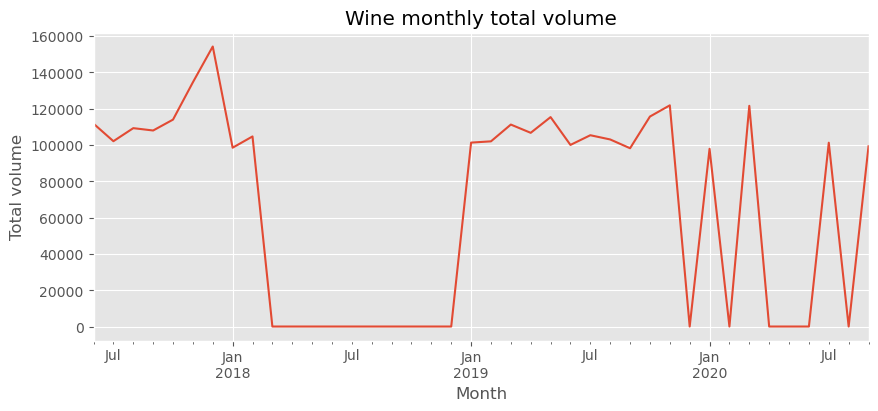

In [49]:
ax = y_wine.plot(figsize=(10,4))
ax.set_title("Wine monthly total volume")
ax.set_xlabel("Month")
ax.set_ylabel("Total volume")
plt.show()

We can clearly see that there is a seasonal trend and a spikes in 2020.

### 5. Forecasting
Fit a seasonal forecasting model

What I’m doing: Train a SARIMAX model with monthly seasonality (12-month cycle) to capture both short-term patterns and seasonal effects.


In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_wine,
    order=(0,1,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=True,
    enforce_invertibility=True
)
# Generate a 12-month forecast
res = model.fit(disp=False)

steps = 12
fc = res.get_forecast(steps=steps)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [47]:
print(forecast_12m.columns)


Index(['forecast', 'lower', 'upper'], dtype='object')


### 6. Visualize forecast

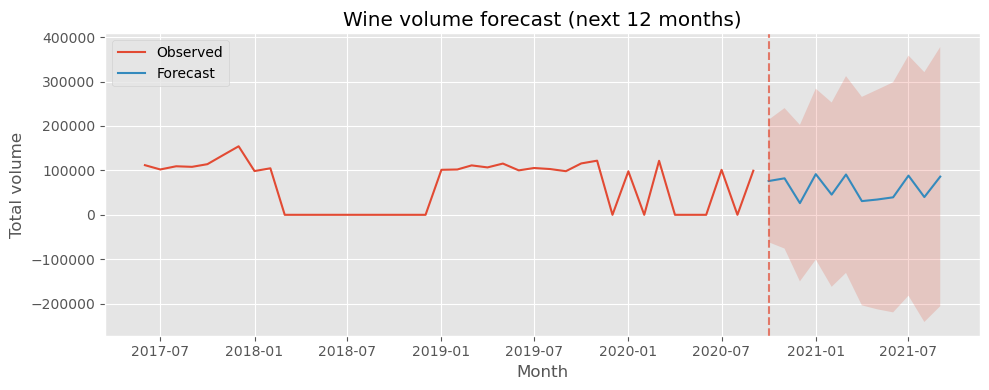

In [48]:
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(10,4))

# Observed
ax.plot(y_wine.index, y_wine.values, label="Observed")

# Forecast
ax.plot(forecast_12m.index, forecast_12m["forecast"].values, label="Forecast")

# Confidence band
ax.fill_between(
    forecast_12m.index,
    forecast_12m["lower"].values,
    forecast_12m["upper"].values,
    alpha=0.2
)

# Optional: mark where forecast starts
ax.axvline(forecast_12m.index.min(), linestyle="--", alpha=0.7)

ax.set_title("Wine volume forecast (next 12 months)")
ax.set_xlabel("Month")
ax.set_ylabel("Total volume")
ax.legend()
plt.tight_layout()
plt.show()



A. Focus on high-volume products (optional)

What I’m doing: Restrict the analysis to the highest-volume SKUs to reduce noise from products with mostly zero sales months.

# Volume Sales
1. Focus on high-volume wine products (reduce noise)

Many wine SKUs have long stretches of zero sales. That intermittent demand adds noise and can make forecasts unstable. In this section, I filter to high-volume wine SKUs so the monthly time series reflects the products that drive most of the volume.

In [60]:

# Basic cleanup
df = df.copy()
df.columns = df.columns.str.strip()

# Numeric conversion
num_cols = ["RETAIL SALES", "RETAIL TRANSFERS", "WAREHOUSE SALES"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

# Total volume metric
df["TOTAL_VOLUME"] = df["RETAIL SALES"] + df["RETAIL TRANSFERS"] + df["WAREHOUSE SALES"]

# Standardize ITEM TYPE text and filter to wine only
df["ITEM TYPE"] = df["ITEM TYPE"].astype(str).str.strip().str.upper()
df_wine = df[df["ITEM TYPE"] == "WINE"].copy()

# Monthly date
df_wine["MONTH_DATE"] = pd.to_datetime(
    df_wine["YEAR"].astype(int).astype(str) + "-" + df_wine["MONTH"].astype(int).astype(str) + "-01"
)


2. Rank wine SKUs by total volume

Sum total volume by SKU across the entire history and rank from highest to lowest.

In [63]:
sku_col = "ITEM CODE"  # SKU identifier
sku_totals = (
    df_wine.groupby(sku_col)["TOTAL_VOLUME"]
    .sum()
    .sort_values(ascending=False)
)

sku_totals.head(10)


ITEM CODE
83399    18694.53
84271    18495.56
85995    18457.83
84678    17306.29
82889    16080.16
73628    12413.07
80911    12093.95
82538    11319.75
75906    11202.97
66125    11018.22
Name: TOTAL_VOLUME, dtype: float64

3. Keep high-volume SKUs (Pareto filter)

Instead of picking an arbitrary number of SKUs, I will keep the set of SKUs that account for the first 90% of total wine volume (Pareto approach). This typically removes low-activity SKUs that contribute lots of zeros.

In [53]:
pareto_target = 0.90  # keep SKUs that make up 90% of volume

cum_share = sku_totals.cumsum() / sku_totals.sum()
keep_skus = cum_share[cum_share <= pareto_target].index

# Always keep at least 1 SKU (edge case)
if len(keep_skus) == 0:
    keep_skus = sku_totals.head(1).index

df_wine_top = df_wine[df_wine[sku_col].isin(keep_skus)].copy()

len(keep_skus), df_wine_top[sku_col].nunique()


(2918, 2918)

4. Rebuild the monthly time series from filtered wine SKUs

Aggregate the filtered dataset into one monthly total series that will be used for visualization and forecasting.

In [54]:
y_wine_top = (
    df_wine_top.groupby("MONTH_DATE")["TOTAL_VOLUME"]
    .sum()
    .asfreq("MS")
    .fillna(0)
    .clip(lower=0)
)

y_wine_top.head(), y_wine_top.tail()


(MONTH_DATE
 2017-06-01     98917.84
 2017-07-01     91146.74
 2017-08-01     97308.49
 2017-09-01     96972.74
 2017-10-01    101558.35
 Freq: MS, Name: TOTAL_VOLUME, dtype: float64,
 MONTH_DATE
 2020-05-01        0.00
 2020-06-01        0.00
 2020-07-01    90756.55
 2020-08-01        0.00
 2020-09-01    88319.43
 Freq: MS, Name: TOTAL_VOLUME, dtype: float64)

5. Validate coverage

Confirm how many SKUs were kept and what share of total wine volume they represent. This makes the filtering choice defensible.

In [55]:
total_volume_all = df_wine["TOTAL_VOLUME"].sum()
total_volume_kept = df_wine_top["TOTAL_VOLUME"].sum()

coverage = total_volume_kept / total_volume_all if total_volume_all != 0 else np.nan

summary = {
    "total_wine_skus": int(df_wine[sku_col].nunique()),
    "kept_wine_skus": int(df_wine_top[sku_col].nunique()),
    "pareto_target": pareto_target,
    "volume_coverage": coverage,
    "total_wine_volume_all": total_volume_all,
    "total_wine_volume_kept": total_volume_kept,
}
summary


{'total_wine_skus': 21300,
 'kept_wine_skus': 2918,
 'pareto_target': 0.9,
 'volume_coverage': np.float64(0.8999719737853608),
 'total_wine_volume_all': np.float64(2638101.5400000005),
 'total_wine_volume_kept': np.float64(2374217.45)}

6. Visualize the filtered wine series

Plot the filtered monthly series to confirm it looks smoother and more forecastable.

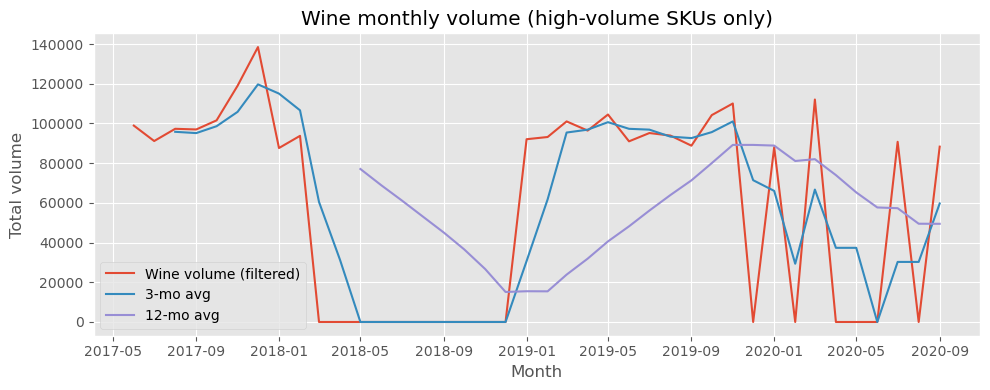

In [56]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(y_wine_top.index, y_wine_top.values, label="Wine volume (filtered)")

# Optional rolling mean overlays
ax.plot(y_wine_top.index, y_wine_top.rolling(3).mean(), label="3-mo avg")
ax.plot(y_wine_top.index, y_wine_top.rolling(12).mean(), label="12-mo avg")

ax.set_title("Wine monthly volume (high-volume SKUs only)")
ax.set_xlabel("Month")
ax.set_ylabel("Total volume")
ax.legend()
plt.tight_layout()
plt.show()


B. Top 15 wine best sellers

Identify the top 15 wine SKUs by total volume across the full time period.

In [58]:

sku_col = "ITEM CODE"
name_col = "ITEM DESCRIPTION"   # optional, helps readability if it exists

# Total volume by SKU
sku_totals = (
    df_wine.groupby(sku_col)["TOTAL_VOLUME"]
    .sum()
    .sort_values(ascending=False)
)

top15_ids = sku_totals.head(15).index

# Build table
top15 = (
    df_wine[df_wine[sku_col].isin(top15_ids)]
    .groupby([sku_col] + ([name_col] if name_col in df_wine.columns else []))["TOTAL_VOLUME"]
    .sum()
    .reset_index()
    .sort_values("TOTAL_VOLUME", ascending=False)
)

# Add share of total wine volume
total_wine_volume = df_wine["TOTAL_VOLUME"].sum()
top15["share_of_wine_volume"] = top15["TOTAL_VOLUME"] / total_wine_volume

top15


,ITEM CODE,ITEM DESCRIPTION,TOTAL_VOLUME,share_of_wine_volume
10,83399,K JACKSON VINT RES CHARD - 750ML,18694.53,0.007086
11,84271,SUTTER HOME CHARD - 187ML,18495.56,0.007011
13,85995,WOODBRIDGE CHARD - 1.5L,18457.83,0.006997
12,84678,APOTHIC CAL RED BLEND - 750ML,17306.29,0.006560
8,82889,LA MARCA PROSECCO - 750ML,16080.16,0.006095
3,73628,ALAMOS MALBEC - 750ML,12413.07,0.004705
6,80911,KIM CRAWFORD S/BLC - 750ML,12093.95,0.004584
7,82538,FRANZIA CHARD BIB - 5L,11319.75,0.004291
5,75906,BLACK BOX MONTEREY CHARD BIB - 3L,11202.97,0.004247
1,66125,CAVIT P/GRIG - 1.5L,11018.22,0.004177
